# Optimizing Throughput: Queues

We've shown the average throughput of llama-jax to be 10 tps short of Ollama (25 vs. 35 running on 64GB M1 MBP). The goal of this series of optimization experiments is to see how closely we can match Ollama's throughput.

## Queues

# Setup

In [1]:
from collections.abc import Callable, Iterator, Sequence
from concurrent.futures import wait,ThreadPoolExecutor
from functools import partial
from queue import SimpleQueue
from time import time_ns as seed

import jax
from jax import Array, numpy as jnp, random
from jax.nn import softmax
import ollama
from pandas import DataFrame
from pydantic import BaseModel
import seaborn as sns
from tqdm.auto import tqdm

import llama_jax as ll
from llama_jax.chat import Message
from llama_jax.checkpoint import ModelConfig
from llama_jax.model import Model
from llama_jax.kvc import KVCache
from llama_jax.tools import default_arg

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



W0000 00:00:1741211162.658151 15159954 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1741211162.666866 15159954 service.cc:145] XLA service 0x12b3eb5f0 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741211162.666877 15159954 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1741211162.668319 15159954 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1741211162.668331 15159954 mps_client.cc:384] XLA backend will use up to 51539214336 bytes on device 0 for SimpleAllocator.


# Parameters

In [2]:
n_prompts = 30
max_tokens = 50

# Prompts

In [3]:
class PromptPool(BaseModel):
    prompts: list[str]

prompt = ll.tools.prompt(
    f"""
    Generate {n_prompts} LLM prompts. Each prompt should pose an interesting question about math and science in 3 to 6 words.
    Your response must be formatted as JSON.
    """
)

response = ollama.chat(
    model="llama3.2:3b", 
    messages=[{"role": "user", "content": prompt}], 
    format=PromptPool.model_json_schema(),
)

prompt_pool = PromptPool.model_validate_json(response.message.content)
prompts = prompt_pool.prompts

prompts

['Can Math Explain Reality?',
 'What is Perfectly Rational Beauty?',
 'Do Geometric Shapes Hold Secrets?',
 'How Do Stars Align Physics?',
 'Is Symmetry a Universal Law?',
 'Do Laws of Nature Vary?',
 'Why Does Time Work Differently?',
 'Are Physical Constants Fixed?',
 'How Do Black Holes Form?',
 'Does Space-Time Matter More?',
 'What is the Speed Limit?',
 'Can Machines Solve Math Problems?',
 'Is Pi an Infinite Answer?',
 'Can Numbers Describe Reality?',
 'Do Fractals Hold Secrets?',
 'How Does Energy Transfer?',
 'Is Gravity a Force?',
 'Do Waves Have Speed Limits?',
 'Why Do Some Laws Fail?',
 'Do All Objects Decay Slowly?',
 'How Much Energy is Lost?',
 'What is the Speed of Light?',
 'Can Machines See Color?',
 'Why Do Plants Grow Taller?',
 'Are Numbers Always Counting?',
 'Does Matter Have a Speed Limit?',
 'Can We Control Gravity?',
 'Is Time Travel Possible?',
 'Can Machines Learn Math Faster?',
 'Do All Physical Laws Apply?',
 'How Does Weather Affect Physics?',
 'Is the U

In [4]:
warmup_prompt = "Why is the sky blue?"

# Building Blocks

In [5]:
Pipeline = Callable[[Sequence[str]], Iterator[str]]


@partial(jax.jit, static_argnames="config")
def transform(
    config: ModelConfig,
    state: Model,
    token_ids: Array,
    position_mask: Array,
    *,
    kvc: KVCache | None = None,
) -> Array | tuple[Array, KVCache]:
    """Transform token_ids into next token logits."""

    # Remember if cache was provided
    external_cache = kvc is not None

    # Defaults
    kvc = default_arg(kvc, default_factory=partial(ll.kvc.create, config))

    # Sanity check
    assert token_ids.ndim == 2

    # Map tokens to embeddings
    x = ll.embeddings.forward(config, state.embeddings, token_ids)

    # Create mask
    mask = ll.attention.attention_mask(config, position_mask)

    # Create mutable kv cache
    kvc_layers = list(kvc)

    # Apply layers
    for i, layer in enumerate(state.layers):
        x, kvc_layers[i] = ll.layer.forward(config, layer, state.rope, mask, x, kvc_layers[i])

    # Convert kv caches back into immutable sequence
    kvc = KVCache(kvc_layers)

    # Apply head
    x = ll.head.forward(config, state.head, x, position_mask)

    # Return updated cache if provided
    if external_cache:
        return x, kvc

    return x


@partial(jax.jit, static_argnames=("temperature", "top_k", "top_p"))
def next_token_id(
    logits: Array,
    *,
    key: Array | None = None,
    temperature: float | None = None,
    top_k: int | None = None,
    top_p: float | None = None,
) -> Array:
    """Select next token id using temperature, top k, and top p sampling."""

    # Temperature
    # -----------

    # Defaults
    temperature = default_arg(temperature, 0.6)

    # If temperature is 0, return the top token
    if temperature == 0:
        return jnp.argmax(logits, axis=-1, keepdims=True)

    # Apply temperature
    logits = logits / temperature

    # Ranking
    # -------

    # Sort logits in descending order, maintaining original indices
    indices = jnp.argsort(logits, axis=-1, descending=True)

    # Top K
    # -----

    # Defaults
    top_k = default_arg(top_k, 50)

    # Apply top k to entire batch at once
    indices = indices[:, :top_k]
    logits = jnp.take_along_axis(logits, indices, axis=-1)

    # Top P
    # -----

    # Defaults
    top_p = default_arg(top_p, 0.9)

    # Convert remaining logits to probabilities
    probs = softmax(logits, axis=-1)

    # Find index where cumulative sum of probs exceeds p
    cumulative_mask = probs.cumsum(axis=-1) <= top_p
    cutoff = jnp.sum(cumulative_mask, axis=-1, keepdims=True)

    # Calculate mask for indicies <= cutoff
    mask = jnp.broadcast_to(jnp.arange(logits.shape[-1]), logits.shape) <= cutoff

    # Zero out logits above cutoff
    logits = jnp.where(mask, logits, 0)

    # Random Selection
    # ----------------

    assert key is not None

    # Randomly choose from remaining logits
    key, subkey = random.split(key)
    selected = random.categorical(subkey, logits, axis=-1)[:, None]

    # Map selected back to original logit indices
    next_token_id = jnp.take_along_axis(indices, selected, axis=-1)

    return next_token_id

In [6]:
config = ll.checkpoint.load_config("Llama3.2-3b-Instruct")
tokenizer = ll.checkpoint.load_tokenizer(config)
model = ll.model.create(config)
executor = ThreadPoolExecutor()

# Pipeline 1: No Queue

In [7]:
def pipeline1(prompts: Sequence[str]) -> Iterator[str]:

    key = random.key(seed())

    for content in prompts:
        
        prompt = ll.chat.render_prompt([Message(role="user", content=content)])
        token_ids, position_mask = tokenizer.encode(prompt)

        x = token_ids
        kvc = ll.kvc.create(config)
        key, *subkeys = random.split(key, max_tokens+1)

        for i in range(max_tokens):
            
            logits, kvc = transform(config, model, x, position_mask, kvc=kvc)
            token_id = next_token_id(logits, key=subkeys[i])

            yield tokenizer.decode(token_id)[0]

            x = token_id

# Pipeline 2: Queued

Separate token encoding/decoding (CPU) from mapping token_ids to next_token_id (GPU).

In [8]:
def pipeline2(prompts: Sequence[str]) -> Iterator[str]:

    input_queue = SimpleQueue()
    output_queue = SimpleQueue()

    def encoder():
        """Encode prompts as token ids."""

        for prompt in prompts:
            prompt = ll.chat.render_prompt([Message(role="user", content=prompt)])
            token_ids, position_mask = tokenizer.encode(prompt)
            
            input_queue.put((token_ids, position_mask))

        input_queue.put(None)

    def transformer():
        """Predict next token id from input token ids."""
        key = random.key(seed())

        while (inputs := input_queue.get()) is not None:
            token_ids, position_mask = inputs
            
            x = token_ids
            kvc = ll.kvc.create(config)
            key, *subkeys = random.split(key, max_tokens+1)

            for i in range(max_tokens):
                logits, kvc = transform(config, model, x, position_mask, kvc=kvc)
                token_id = next_token_id(logits, key=subkeys[i])

                output_queue.put(token_id)

                x = token_id
            
        output_queue.put(None)

    # Launch background jobs
    tasks = [
        executor.submit(encoder),
        executor.submit(transformer),
    ]

    # Decode generated token ids
    while (token_id := output_queue.get()) is not None:
        yield tokenizer.decode(token_id)[0]
    
    wait(tasks)

# Experiment

In [9]:
def warmup(pipeline: Pipeline):
    jax.clear_caches()

    for _ in tqdm(pipeline([warmup_prompt]), desc="Warmup", total=max_tokens, leave=False):
        pass


def run(pipeline: Pipeline):

    with ll.render.token_view() as tv:
        for token in pipeline(prompts):
            tv.add_token(token)
    
    return tv.tps

In [10]:
pipelines = [
    pipeline1,
    pipeline2,
]

metrics = []

for i, pipeline in enumerate(tqdm(pipelines, desc="Pipelines")):
    
    warmup(pipeline)

    tps = run(pipeline)

    metrics.append({"pipeline": i, "tps": tps})

Pipelines:   0%|          | 0/2 [00:00<?, ?it/s]

Warmup:   0%|          | 0/50 [00:00<?, ?it/s]

Output()

Warmup:   0%|          | 0/50 [00:00<?, ?it/s]

Output()

# Analysis

In [11]:
data = DataFrame(metrics)

<Axes: xlabel='pipeline', ylabel='tps'>

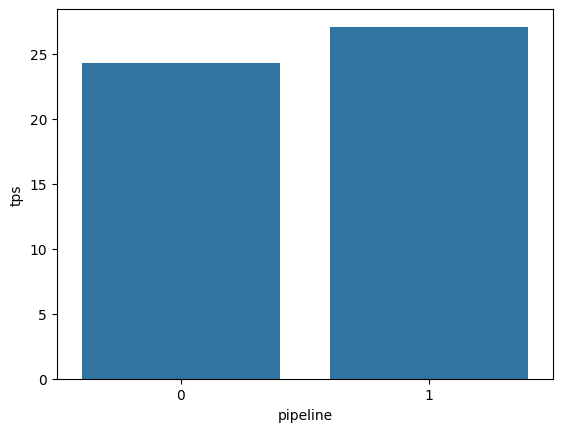

In [12]:
sns.barplot(data, x="pipeline", y="tps")